# Exploratory Data Analysis (EDA)
Within the crisp-dm framework this can be seen as `Explore data`

## Overview
This EDA aims to provide a comprehensive first look at the ART500K Toy Dataset, assessing its structure, basic statistics, distributions, relationships, potential data quality issues, and initial implications for downstream modeling. All findings here will inform both the data preparation phase and modeling choices.

## Loading packages

In [2]:
import pandas as pd
import os

SEED=42

## Importing data

In [3]:
image_dir = '../data/toy_dataset/'

labels_path = '../data/toy_dataset_label.csv'

df = pd.read_csv(labels_path, sep='\t')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43455 entries, 0 to 43454
Data columns (total 13 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ID         43455 non-null  int64 
 1   FILE       43454 non-null  object
 2   AUTHOR     43455 non-null  object
 3   BORN-DIED  43455 non-null  object
 4   TITLE      43455 non-null  object
 5   DATE       43455 non-null  object
 6   TECHNIQUE  43455 non-null  object
 7   LOCATION   43455 non-null  object
 8   FORM       43455 non-null  object
 9   TYPE       43455 non-null  object
 10  SCHOOL     43455 non-null  object
 11  TIMELINE   43455 non-null  object
 12  URL        43455 non-null  object
dtypes: int64(1), object(12)
memory usage: 4.3+ MB


In [4]:
df.sample(n=3)

,ID,FILE,AUTHOR,BORN-DIED,TITLE,DATE,TECHNIQUE,LOCATION,FORM,TYPE,SCHOOL,TIMELINE,URL
31808,31809,31809.jpg,RAFFAELLO Sanzio,"(b. 1483, Urbino, d. 1520, Roma)",The Parnassus,1509-10,"Fresco, width at base 670 cm","Stanza della Segnatura, Palazzi Pontifici, Vat...",painting,mythological,Italian,1501-1550,http://www.wga.hu/html/r/raphael/4stanze/1segn...
798,799,799.jpg,"ANGELICO, Fra","(b. ca. 1400, Vicchio nell Mugello, d. 1455, R...",Annunciation (Cell 3),1440-42,"Fresco, 176 x 148 cm","Convento di San Marco, Florence",painting,religious,Italian,1401-1450,http://www.wga.hu/html/a/angelico/09/cells/03_...
23971,23972,23972.jpg,MASTER of Saint Veronica,(active 1400-1420 in Cologne),Triptych (open),c. 1410,"Panel, 70 x 32,5 cm (centre), 70 x 16 cm (each...","Heinz Kisters Collection, Kreuzlingen",painting,religious,German,1401-1450,http://www.wga.hu/html/m/master/veronica/tript...


In [3]:
df.isnull().sum()

ID           0
FILE         1
AUTHOR       0
BORN-DIED    0
TITLE        0
DATE         0
TECHNIQUE    0
LOCATION     0
FORM         0
TYPE         0
SCHOOL       0
TIMELINE     0
URL          0
dtype: int64

The csv is loaded into the dataframe with the correct count of rows except for the FILE row. This is missing one value.
Due to time constraint this row will be dropped for this iteration

In [5]:
df = df.dropna(subset=['FILE'])

The columns match the stated columns in `/02_describe_data.md`

The image path will be added to the dataframe to easily load images when needed

In [5]:
df['IMAGE_PATH'] = df['FILE'].apply(lambda x: os.path.join(image_dir, x))

missing_images = df[~df['IMAGE_PATH'].apply(os.path.exists)]
print(f"Number of missing image files: {len(missing_images)}")

Number of missing image files: 2


In [6]:
print(display(missing_images))

,ID,FILE,AUTHOR,BORN-DIED,TITLE,DATE,TECHNIQUE,LOCATION,FORM,TYPE,SCHOOL,TIMELINE,URL,IMAGE_PATH
19561,19562,19562.jpg,"HUNT, William Holman","(b. 1827, London, d. 1910, London)",The Lady of Shalott (detail),1886-1905,Oil on canvas,"Wadsworth Atheneum, Hartford",painting,other,English,1801-1850,http://www.wga.hu/html/h/hunt/y_lady183c.html,../data/toy_dataset/19562.jpg
21911,21912,21912.jpg,"LISSE, Dirck van der","(b. 1607, Breda, d. 1669, Den Haag)",Landscape with Diana and Actaeon,-,"Oil on panel, 35 x 47 cm",Private collection,painting,landscape,Dutch,1601-1650,http://www.wga.hu/html/l/lisse/lisse_c.html,../data/toy_dataset/21912.jpg


None


In [7]:
df = df.drop(missing_images.index).reset_index(drop=True)

These two rows do not exist in the toy_dataset folder. After a manual check this is confirmed twice. These two rows will be dropped from the dataframe due to time contraint

## Data completeness and types
In the following code blocks there will be a check on how complete the data is and what is consists of and if the types need to be refined

In [8]:
df.sample(n=6)

,ID,FILE,AUTHOR,BORN-DIED,TITLE,DATE,TECHNIQUE,LOCATION,FORM,TYPE,SCHOOL,TIMELINE,URL,IMAGE_PATH
36197,36200,36200.jpg,"SISLEY, Alfred","(b. 1839, Paris, d. 1899, Moret-sur-Loing)",Saint-Martin Canal in Paris,1870,"Oil on canvas, 55 x 73 cm","Oskar Reinhart Collection, Winterthur",painting,landscape,French,1851-1900,http://www.wga.hu/html/s/sisley/2other/paris1....,../data/toy_dataset/36200.jpg
32360,32363,32363.jpg,REMBRANDT Harmenszoon van Rijn,"(b. 1606, Leiden, d. 1669, Amsterdam)",The Denial of Peter (detail),1660,Oil on canvas,"Rijksmuseum, Amsterdam",painting,religious,Dutch,1601-1650,http://www.wga.hu/html/r/rembrand/14biblic/63n...,../data/toy_dataset/32363.jpg
30621,30624,30624.jpg,"PISANO, Nicola",(active 1258-1278),Adoration of the Magi,1260,"Marble, 85 x 113 cm","Baptistry, Pisa",sculpture,religious,Italian,1251-1300,http://www.wga.hu/html/p/pisano/nicola/1pisa_2...,../data/toy_dataset/30624.jpg
23890,23893,23893.jpg,MASTER of Flémalle,"(b. ca. 1375, Valenciennes, d. 1444, Tournai)",St Veronica,c. 1410,"Oil on wood, 151,5 x 61 cm","Städelsches Kunstinstitut, Frankfurt",painting,religious,Flemish,1401-1450,http://www.wga.hu/html/m/master/flemalle/tript...,../data/toy_dataset/23893.jpg
14258,14259,14259.jpg,GASPARE DA PADOVA,(active 1466-1517 in Rome),Caesar: Commentaries,1490s,Manuscript (Ms. 453),"Biblioteca Casanatense, Rome",illumination,other,Italian,1451-1500,http://www.wga.hu/html/g/gaspare/caesar.html,../data/toy_dataset/14259.jpg
35877,35880,35880.jpg,"SIGNORELLI, Luca","(b. ca. 1450, Cortona, d. 1523, Cortona)",Resurrection of the Flesh (detail),1499-1502,Fresco,"Chapel of San Brizio, Duomo, Orvieto",painting,religious,Italian,1451-1500,http://www.wga.hu/html/s/signorel/brizio/2/3re...,../data/toy_dataset/35880.jpg


With this sample there is a good sense of how the data looks like, the column ID clearly shows integers and is not expected to deviate. The FILE, AUTHOR, TITLE are good as string(object) types

now the unique values for the rows will be printed together with a percentage of how unique they are to find categorical types

In [9]:
for col in df.columns:
    unique_count = df[col].nunique()
    total_count = len(df)
    print(f"{col}: {unique_count} unique values ({unique_count/total_count:.2%} of {total_count})")

ID: 43452 unique values (100.00% of 43452)
FILE: 43452 unique values (100.00% of 43452)
AUTHOR: 4991 unique values (11.49% of 43452)
BORN-DIED: 7151 unique values (16.46% of 43452)
TITLE: 27090 unique values (62.34% of 43452)
DATE: 4958 unique values (11.41% of 43452)
TECHNIQUE: 21437 unique values (49.33% of 43452)
LOCATION: 4064 unique values (9.35% of 43452)
FORM: 13 unique values (0.03% of 43452)
TYPE: 10 unique values (0.02% of 43452)
SCHOOL: 26 unique values (0.06% of 43452)
TIMELINE: 24 unique values (0.06% of 43452)
URL: 43452 unique values (100.00% of 43452)
IMAGE_PATH: 43452 unique values (100.00% of 43452)


The columns `FORM`, `TYPE`, `SCHOOL`, `TIMELINE` and `LOCATION` show they do not occur many times in the dataframe and going from the column name itself it would be logical if these are categories

In [10]:
categorical_columns = ['FORM', 'TYPE', 'SCHOOL', 'TIMELINE', 'LOCATION']

for col in categorical_columns:
    print(f"Unique values in {col} before cleaning:")
    print(df[col].unique())
    print("\n")

Unique values in FORM before cleaning:
['painting' 'ceramics' 'sculpture' 'graphics' 'architecture'
 'stained-glass' 'metalwork' 'illumination' 'mosaic' 'others' 'furniture'
 'tapestry' 'glassware']


Unique values in TYPE before cleaning:
['mythological' 'genre' 'portrait' 'landscape' 'religious' 'other'
 'historical' 'interior' 'still-life' 'study']


Unique values in SCHOOL before cleaning:
['German' 'Danish' 'Spanish' 'French' 'Italian' 'Dutch' 'Scottish'
 'Flemish' 'Netherlandish' 'Swiss' 'Russian' 'Greek' 'Other' 'American'
 'English' 'Austrian' 'Portuguese' 'Bohemian' 'Catalan' 'Hungarian'
 'Irish' 'Norwegian' 'Polish' 'Swedish' 'Belgian' 'Finnish']


Unique values in TIMELINE before cleaning:
['1601-1650' '1851-1900' '1451-1500' '1501-1550' '1751-1800' '1551-1600'
 '1801-1850' '1701-1750' '1651-1700' '1301-1350' '1401-1450' '1351-1400'
 '1151-1200' '1251-1300' '1101-1150' '1001-1050' '1201-1250' '1051-1100'
 '0801-0850' '0751-0800' '0851-0900' '0951-1000' '0701-0750' '0901-0950

All columns are clean without duplicates, `LOCATION` has to be inspected further to check if there are differences in the values that should be the same but are not

In [11]:
def LOCATION_normalized_against_variants():
    locations_normalized = df['LOCATION'].str.lower().str.strip()

    # Group original variants by normalized form
    groups = df.groupby(locations_normalized)['LOCATION'].apply(list)

    # Filter groups with more than one distinct variant
    groups_with_variants = groups[groups.apply(lambda x: len(set(x)) > 1)]

    # Display the normalized key and its variants
    for norm_loc, variants in groups_with_variants.items():
        print(f"Normalized: '{norm_loc}'")
        print(f"Variants: {set(variants)}\n")

LOCATION_normalized_against_variants()

Normalized: 'akademie der bildenden künste, vienna'
Variants: {'Akademie der bildenden Künste, Vienna', 'Akademie der Bildenden Künste, Vienna'}

Normalized: 'museum boijmans van beuningen, rotterdam'
Variants: {'Museum Boijmans van Beuningen, Rotterdam', 'Museum Boijmans Van Beuningen, Rotterdam'}

Normalized: 'museum der bildenden künste, leipzig'
Variants: {'Museum der bildenden Künste, Leipzig', 'Museum der Bildenden Künste, Leipzig'}

Normalized: 'museum of modern art, new york'
Variants: {'Museum of Modern Art, new York', 'Museum of Modern Art, New York'}

Normalized: 'musée cantonal des beaux-arts, lausanne'
Variants: {'Musée cantonal des Beaux-Arts, Lausanne', 'Musée Cantonal des Beaux-Arts, Lausanne'}

Normalized: 'musée d'art et d'histoire, geneva'
Variants: {"Musée d'art et d'histoire, Geneva", "Musée d'Art et d'Histoire, Geneva"}

Normalized: 'musée des arts décoratifs, paris'
Variants: {'Musée des Arts Décoratifs, Paris', 'Musée des Arts décoratifs, Paris'}

Normalized: 'm

As can be seen above there can be small variations between usage of capital letters. To keep as close as possible to the original place and name of location the most used version will be used as a replacement when there are multiple versions

In [12]:
locations_normalized = df['LOCATION'].str.strip().str.lower()

# Group original variants by normalized form
groups = df.groupby(locations_normalized)['LOCATION'].apply(list)

# Get the most frequent variant (mode) in each group
def most_frequent_variant(variants):
    return pd.Series(variants).mode()[0]

canonical_locations = groups.apply(most_frequent_variant)

# Overwrite LOCATION by mapping normalized to canonical variant
df['LOCATION'] = locations_normalized.map(canonical_locations)

In [13]:
LOCATION_normalized_against_variants()

No output for the function

Now the top 3 values for each categorie will be printed

In [14]:
top = 3

for col in categorical_columns:
    print(f"\nTop {top} values for '{col}':")
    counts = df[col].value_counts().head(top)
    for idx, (val, count) in enumerate(counts.items(), 1):
        print(f"  {idx}. {val}: {count}")


Top 3 values for 'FORM':
  1. painting: 30003
  2. sculpture: 4766
  3. graphics: 3813

Top 3 values for 'TYPE':
  1. religious: 17838
  2. portrait: 5640
  3. landscape: 4341

Top 3 values for 'SCHOOL':
  1. Italian: 18150
  2. French: 6804
  3. Dutch: 5059

Top 3 values for 'TIMELINE':
  1. 1501-1550: 6327
  2. 1601-1650: 6115
  3. 1451-1500: 5181

Top 3 values for 'LOCATION':
  1. Private collection: 5705
  2. Musée du Louvre, Paris: 1790
  3. The Hermitage, St. Petersburg: 1313


From these outputs the conclusion can be made that these can be seen as categories. The values will also be stripped of any leading and trailing whitespace if there is any

In [15]:
categorical_cols = ['FORM', 'TYPE', 'SCHOOL', 'TIMELINE', 'LOCATION']

for col in categorical_cols:
    df[col] = df[col].astype(str).str.strip()
    df[col] = df[col].astype('category')
    print(f"Number of unique values for column {col}: {df[col].nunique()}")

Number of unique values for column FORM: 13
Number of unique values for column TYPE: 10
Number of unique values for column SCHOOL: 26
Number of unique values for column TIMELINE: 24
Number of unique values for column LOCATION: 4055


When looking at the sample output above the `TECHNIQUE` column could possibly be a categorie but due to extra information about sizes this is not a clean category without dissecting the column. Due to time constraint this column will be dropped in this iteration

The `BORD-DIED` column shows a string that has to be dissected into multiple columns. The values in the rows are not always according to the same format, due to this the decision will be made to drop this column in this iteration

In [16]:
df = df.drop(['TECHNIQUE', 'BORN-DIED'], axis=1)

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43452 entries, 0 to 43451
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   ID          43452 non-null  int64   
 1   FILE        43452 non-null  object  
 2   AUTHOR      43452 non-null  object  
 3   TITLE       43452 non-null  object  
 4   DATE        43452 non-null  object  
 5   LOCATION    43452 non-null  category
 6   FORM        43452 non-null  category
 7   TYPE        43452 non-null  category
 8   SCHOOL      43452 non-null  category
 9   TIMELINE    43452 non-null  category
 10  URL         43452 non-null  object  
 11  IMAGE_PATH  43452 non-null  object  
dtypes: category(5), int64(1), object(6)
memory usage: 2.7+ MB


### Number of images and labels
Check to verify if the surface level data description is correct

In [18]:
image_files = set(os.listdir(image_dir))
metadata_files = set(df['FILE'])

# Images with metadata
matched_images = image_files & metadata_files

# Images missing in metadata
missing_in_metadata = image_files - metadata_files

# Metadata missing images
missing_images = metadata_files - image_files

print(f"Matched images: {len(matched_images)}")
print(f"Images not in metadata: {len(missing_in_metadata)}")
print(f"Metadata entries with missing image: {len(missing_images)}")

Matched images: 43452
Images not in metadata: 1
Metadata entries with missing image: 0


There is a mismatch between the existing labels and the images in the dataset (might be solved by dropping 2 images and one null value?)

*Exploring the basic features and cleaning what is needed will be halted here to continue with the visualization*

## Image data
In the preview of the images via the local folder it could be seen that the images are of various sizes, now a sample of the images will be loaded in the notebook to inspect and verify this

In [19]:
from pathlib import Path
from PIL import Image
import matplotlib.pyplot as plt

In [20]:
img_validation_df = df.sample(n=100, random_state=SEED).copy()

widths, heights, bad = [], [], []
for path in img_validation_df['IMAGE_PATH']:
    try:
        pure_path = Path(path)
        with Image.open(pure_path) as img:
            w, h = img.size
        widths.append(w)
        heights.append(h)
    except Exception:
        bad.append(path)
        widths.append(None)
        heights.append(None)

img_validation_df['img_width'] = widths
img_validation_df['img_height'] = heights

print(f"Failed to open {len(bad)} images out of 100\n")
print(img_validation_df[['img_width', 'img_height']].describe())

Failed to open 0 images out of 100

         img_width   img_height
count   100.000000   100.000000
mean    916.820000  1058.060000
std     229.528959   224.932934
min     400.000000   600.000000
25%     763.750000   900.000000
50%     900.000000  1024.000000
75%    1082.750000  1200.000000
max    1455.000000  1600.000000


All images loaded succesfully. There is a difference in sizes

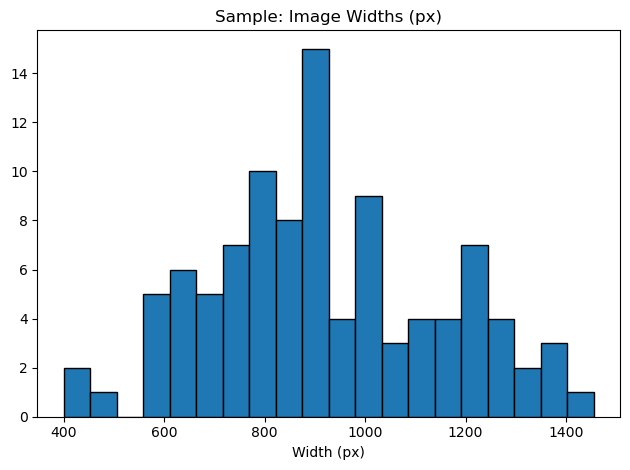

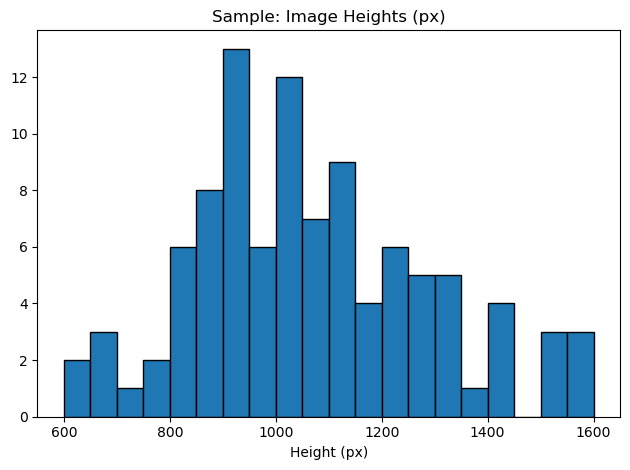

In [21]:
plt.figure()
plt.hist(
    img_validation_df['img_width'].dropna(),
    bins=20,
    edgecolor='black',
    linewidth=1
)
plt.title('Sample: Image Widths (px)')
plt.xlabel('Width (px)')
plt.tight_layout()

plt.figure()

plt.hist(
    img_validation_df['img_height'].dropna(),
    bins=20,
    edgecolor='black',
    linewidth=1
)
plt.title('Sample: Image Heights (px)')
plt.xlabel('Height (px)')
plt.tight_layout()

plt.show()

The histogram shows a variety in image widths and heights, this needs to be normalised before usage

## Visualization

### Bar plots

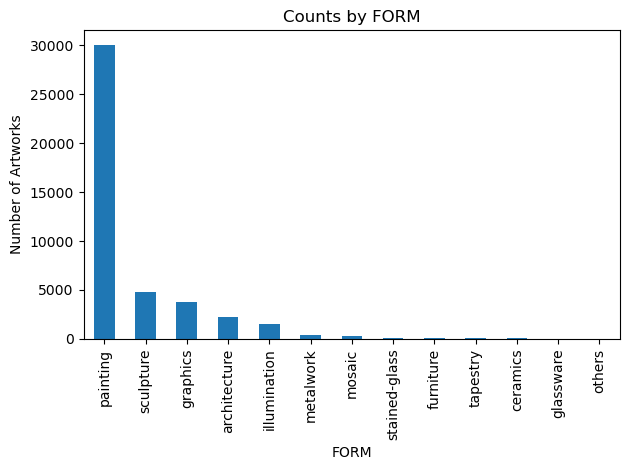

In [22]:
plt.figure()
df['FORM'].value_counts().plot.bar()
plt.title('Counts by FORM')
plt.ylabel('Number of Artworks')
plt.tight_layout()

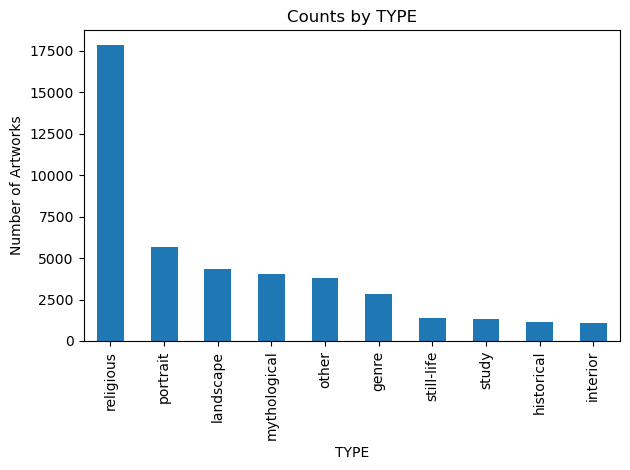

In [23]:
plt.figure()
df['TYPE'].value_counts().plot.bar()
plt.title('Counts by TYPE')
plt.ylabel('Number of Artworks')
plt.tight_layout()

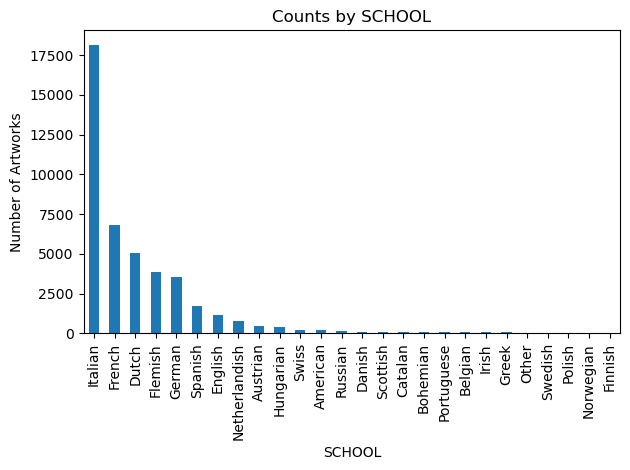

In [24]:
plt.figure()
df['SCHOOL'].value_counts().plot.bar()
plt.title('Counts by SCHOOL')
plt.ylabel('Number of Artworks')
plt.tight_layout()

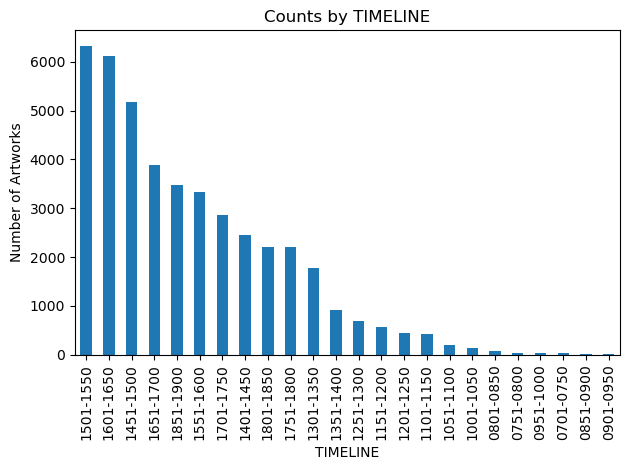

In [25]:
plt.figure()
df['TIMELINE'].value_counts().plot.bar()
plt.title('Counts by TIMELINE')
plt.ylabel('Number of Artworks')
plt.tight_layout()

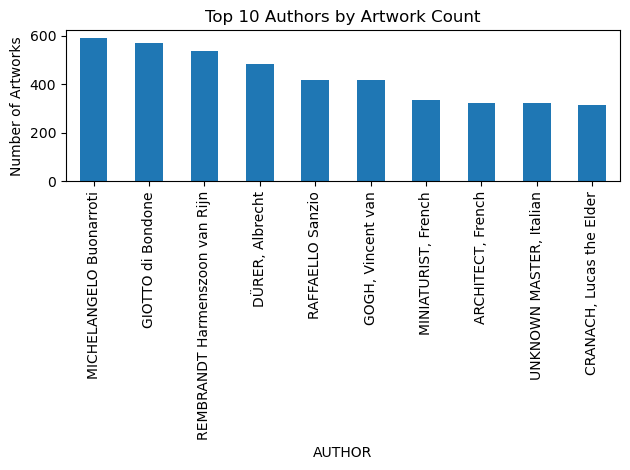

In [26]:
plt.figure()
df['AUTHOR'].value_counts().head(10).plot.bar()
plt.title('Top 10 Authors by Artwork Count')
plt.ylabel('Number of Artworks')
plt.tight_layout()

### Histogram

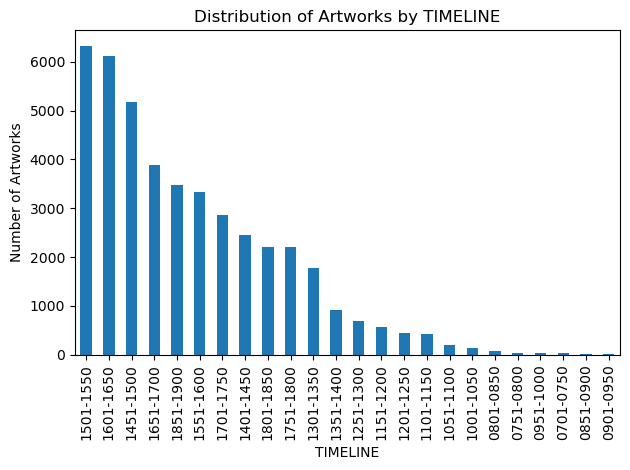

In [27]:
plt.figure()
df['TIMELINE'].value_counts().plot.bar()
plt.title('Distribution of Artworks by TIMELINE')
plt.xlabel('TIMELINE')
plt.ylabel('Number of Artworks')
plt.tight_layout()
plt.show()

# SUNBURST does not render?

In [31]:
import plotly.express as px

top_locations = df['LOCATION'].value_counts().nlargest(2).index
top_types = df['TYPE'].value_counts().nlargest(3).index
top_timelines = df['TIMELINE'].value_counts().nlargest(3).index

filtered_df = df[
    df['LOCATION'].isin(top_locations) &
    df['TYPE'].isin(top_types) &
    df['TIMELINE'].isin(top_timelines)
]

agg_df = (
    filtered_df
    .groupby(['LOCATION', 'TYPE', 'TIMELINE'], observed=True)
    .size()
    .reset_index(name='COUNT')
)

print("Agg_df", agg_df.shape)
print("filter_df shape", filtered_df.shape)

Agg_df (16, 4)
filter_df shape (1500, 12)


In [34]:
print(agg_df.head())

                 LOCATION       TYPE   TIMELINE  COUNT
0  Musée du Louvre, Paris  landscape  1501-1550      2
1  Musée du Louvre, Paris  landscape  1601-1650     33
2  Musée du Louvre, Paris   portrait  1451-1500     33
3  Musée du Louvre, Paris   portrait  1501-1550     41
4  Musée du Louvre, Paris   portrait  1601-1650     41


In [36]:
fig = px.sunburst(
    agg_df,
    path=['LOCATION', 'TYPE', 'TIMELINE'],
    values='COUNT',
    title='Artworks by Location, Type, and Timeline (Top 3 of Each)',
    width=1200, height=800
)

# fig.show()
fig.write_html("sunburst.html", include_plotlyjs='inline', full_html=True)

c:\Users\laure\anaconda3\Lib\site-packages\plotly\express\_core.py:1619: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

c:\Users\laure\anaconda3\Lib\site-packages\plotly\express\_core.py:1619: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

c:\Users\laure\anaconda3\Lib\site-packages\plotly\express\_core.py:1619: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



In [38]:
df.sample(n=10)

,ID,FILE,AUTHOR,TITLE,DATE,LOCATION,FORM,TYPE,SCHOOL,TIMELINE,URL,IMAGE_PATH
36812,36815,36815.jpg,"STIELER, Karl Joseph",King Ludwig I in his Coronation Robes,1826,"Neue Pinakothek, Munich",painting,portrait,German,1801-1850,http://www.wga.hu/html/s/stieler/ludwig1.html,../data/toy_dataset/36815.jpg
2731,2732,2732.jpg,"BALASSI, Mario",Santa Margherita,-,Private collection,painting,religious,Italian,1601-1650,http://www.wga.hu/html/b/balassi/balassi3.html,../data/toy_dataset/2732.jpg
41237,41240,41240.jpg,"VERHULST, Rombout",Bust of Marie von Reygersberg,-,"Rijksmuseum, Amsterdam",sculpture,portrait,Flemish,1651-1700,http://www.wga.hu/html/v/verhulst/reygersb.html,../data/toy_dataset/41240.jpg
16106,16107,16107.jpg,GISLEBERTUS,Last Judgment (detail),1130-45,"Cathedral of Saint-Lazare, Autun",sculpture,religious,French,1101-1150,http://www.wga.hu/html/g/gisleber/2lastj2.html,../data/toy_dataset/16107.jpg
5859,5860,5860.jpg,"BRONZINO, Agnolo",Portrait of a Man Holding a Statuette,1545-55,"Musée du Louvre, Paris",painting,portrait,Italian,1501-1550,http://www.wga.hu/html/b/bronzino/2/man_stat.html,../data/toy_dataset/5860.jpg
13369,13370,13370.jpg,"FLORIS, Frans","The Sacrifice of Jesus Christ, Son of God, Gat...",1562,"Musée du Louvre, Paris",painting,religious,Flemish,1551-1600,http://www.wga.hu/html/f/floris/frans/sacrific...,../data/toy_dataset/13370.jpg
30119,30122,30122.jpg,PIERO DELLA FRANCESCA,7a. Finding of the True Cross,1452-66,"San Francesco, Arezzo",painting,religious,Italian,1451-1500,http://www.wga.hu/html/p/piero/2/7/7find02.html,../data/toy_dataset/30122.jpg
11195,11196,11196.jpg,DOMENICO DI MICHELINO,Dante Illuminating Florence with his Poem (det...,1465,"Museo dell'Opera del Duomo, Florence",painting,mythological,Italian,1451-1500,http://www.wga.hu/html/d/domenico/michelin/dan...,../data/toy_dataset/11196.jpg
35144,35147,35147.jpg,"SANSOVINO, Jacopo",Bust of Tommaso Rangone,1557,"Ateneo Veneto, Venice",sculpture,other,Italian,1501-1550,http://www.wga.hu/html/s/sansovin/jacopo/2/ran...,../data/toy_dataset/35147.jpg
23529,23532,23532.jpg,MASACCIO,St Peter Healing the Sick with his Shadow (det...,1426-27,"Cappella Brancacci, Santa Maria del Carmine, F...",painting,religious,Italian,1401-1450,http://www.wga.hu/html/m/masaccio/brancacc/st_...,../data/toy_dataset/23532.jpg


In [ ]:
# Grid where columns are the art form with example below the header
# Sankey diagram starting with the school to type and then form 
# clustering artworks based on embeddings (maybe visible clusters related to form or type? / Umap?)

To speed up the first iteration all other visualizations will be done in a future iteration.

# Conclusion

While the ART500K Toy Dataset provides a broad selection of artworks with categorical metadata for type, form, timeperiod, etc, it lacks explicit labels for fine grained art movements or curated collections. This makes direct modeling or analysis of movement level curation not feasible. Although the TIMELINE field could be used as a loose placeholder, this would introduce additional noise and does not substitute for explicit movement annotation.

Without a ground truth for collections, the fit check phase in this iteration will use synthetic groupings based on available metadata (type, period). The results will show technical feasibility for such groupings but is unlikely to capture the complexity of real curatorial practice. Outcomes from this prototype will be reviewed and lessons learned will inform if project objectives should be refined or rescoped in following iterations.

*Key EDA outcomes:*
- Absence of explicit movement or style labels.
- All label records are now reliably linked to existing image files, with irrelevant or ambiguous fields removed.
- Focusing on paintings (FORM) and four types with enough data availability (TYPE: religious, portrait, landscape, mythological) provides a relevant subset for the initial modeling phase.
- Normalization of categorical variables and removal of problematic columns reduces risk of mislabeling and improves data quality.

*Remaining challenges:*
- Variation in image sizes must be addressed in image preprocessing.
- Several metadata fields remain inconsistently formatted or unprocessed, and may require further cleaning or enrichment for future iterations.

*Feasibility:*
Despite these constraints the dataset supports meaningful prototyping of fit-checks and basic grouping based on the selected metadata fields. Insights from this first cycle will directly inform the direction and scope of future project work.